<h1 style="text-align:center;"> Project Showcase Challenge</h1>
 <h2 style="text-align:center;"> Image Detection Using PyTorch</h2>

## Team Members
* Ishan Arora
* Sankalp Dayal

## Introdution:
We will be using Genreative Adversial Networks .First we will train our model and after that we will generate new images from it.We will also use DCGAN which is an extension of GAN

We will be using Celeb Dataset avaliable easily at any sites like kaggle.The dataset is stored on our Drive(@Ishan Arora) we will connect with the drve and unzip the dataset# Connect notebook to google drive

## Step1:Importing Libraries and Connecting to Google Drive

In [ ]:
import os
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### We  created a folder in my drive,mounted succesfully with Colab and Celebrity Dataset was available on kaggle.SO  Data folder in @Ishan Arora's drive consists of zipped dataset.FIrst We will unzip it

In [0]:

os.chdir('/content/drive/My Drive/')
os.getcwd()

'/content/drive/My Drive'

In [0]:
# Checking if the Data Exists which I (@Ishan Arora) made in my google drive

os.path.exists('data')
       

In [0]:
os.chdir('data')

In [0]:
!unzip img_align_celeba.zip

After that we moved the unzipped part into the Data Folder by the name of Celeb_Images. So we will go inside the Data folder by os.chdir 

In [0]:
os.chdir('..')

In [ ]:
#Importing some more of the libraries


import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils



## Now we will Define some inputs that we want to use.



In [0]:
#Just confirming wheather we are un right directory or not
os.getcwd()

'/content/drive/My Drive/data'

In [0]:

dataroot = "celeb_images"
workers = 2
batch_size = 128
image_size = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
nc = 3
nz = 100
ngf = 64
ndf = 64




Since we are working in Google Colab we have a GPU so will set the GPU to 1


In [ ]:
ngpu=1

Loading the image dataset and using the tranform function

In [0]:

dataset = dset.ImageFolder('celeb_images',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f419eacb5c0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f419e60fef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

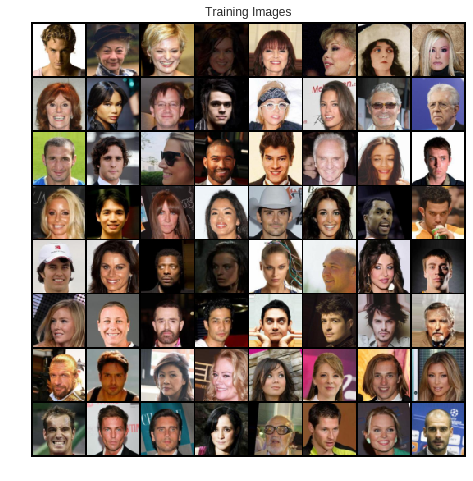

In [0]:

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## We will Specify Custom Weights


### As learnt in lesson 2 of the course we will use ReLu as our activation function .

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Now to randomly initialise the weights we will apply the `weights_init` function



In [0]:
netG = Generator(ngpu).to(device)




netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)





### We will make a binary classification neural network to classify whether the images are real or fake 



In [0]:
class Classifier(nn.Module):
    def __init__(self, ngpu):
        super(Classifier, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
netD = Discriminator(ngpu).to(device)

netD.apply(weights_init)





### We will now initialise the loss function 


In [0]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Now it is some trianing time

We will train both our classifier and generator. Since we are new to GAN we will take help from a few resources.



**First we will train the Classifier which will tell weather the image is real or fake.**


**After that we will train the Generator. Genrator will help us generate us some fake images

**We will also print the Loss of Classifier and Generator along with training**






In [0]:
list_of_images = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 1
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

       
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print(% (epoch, num_epochs, i, len(dataloader),   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print(datetime.datetime.now())
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/1][0/1058]	Loss_D: 0.2739	Loss_G: 4.6440	D(x): 0.8688	D(G(z)): 0.0331 / 0.0194
2019-01-29 06:44:08.461288
[0/1][50/1058]	Loss_D: 0.5710	Loss_G: 3.2135	D(x): 0.7143	D(G(z)): 0.0592 / 0.0644
2019-01-29 06:59:11.763603
[0/1][100/1058]	Loss_D: 1.6877	Loss_G: 4.9473	D(x): 0.3765	D(G(z)): 0.0022 / 0.0173
2019-01-29 07:14:43.101572
[0/1][150/1058]	Loss_D: 0.5243	Loss_G: 3.6280	D(x): 0.8771	D(G(z)): 0.2432 / 0.0498
2019-01-29 07:30:05.974130
[0/1][200/1058]	Loss_D: 1.1302	Loss_G: 1.2130	D(x): 0.4858	D(G(z)): 0.0206 / 0.3958
2019-01-29 07:45:55.675977
[0/1][250/1058]	Loss_D: 2.1336	Loss_G: 10.7011	D(x): 0.9679	D(G(z)): 0.7750 / 0.0002
2019-01-29 08:01:26.628357
[0/1][300/1058]	Loss_D: 0.9682	Loss_G: 7.4535	D(x): 0.5332	D(G(z)): 0.0015 / 0.0013
2019-01-29 08:16:32.066547
[0/1][350/1058]	Loss_D: 0.5819	Loss_G: 4.8979	D(x): 0.8531	D(G(z)): 0.2795 / 0.0156
2019-01-29 08:31:49.526526
[0/1][400/1058]	Loss_D: 1.3605	Loss_G: 4.3650	D(x): 0.3905	D(G(z)): 0.0079 / 0.0290
2019

## Final Results





After extensive training we will compare the real images randomly selected.

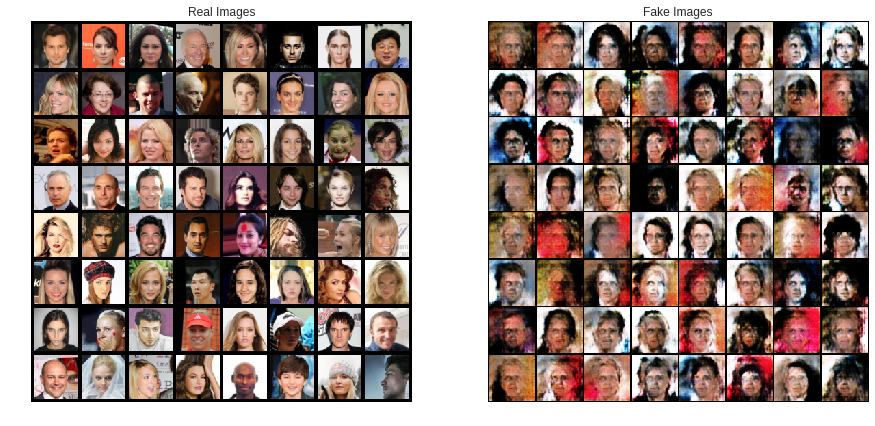

In [0]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Conclusion



We generated fake images from with the help of Generator and Classifier by succesfully training our GAN model in PyTorch